In [12]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score

In [13]:
events_dict = {
    'BLUE: first_blood': 0,
    'BLUE: dragon': 1,
    'BLUE: herald': 2,
    'BLUE: first_tower_top': 3,
    'BLUE: first_tower_mid': 4,
    'BLUE: first_tower_bot': 5,
    'BLUE: second_tower_top': 6,
    'BLUE: second_tower_mid': 7,
    'BLUE: second_tower_bot': 8,
    'BLUE: third_tower_top': 9,
    'BLUE: third_tower_mid': 10,
    'BLUE: third_tower_bot': 11,
    'BLUE: inhibitor_top': 12,
    'BLUE: inhibitor_mid': 13,
    'BLUE: inhibitor_bot': 14,
    'BLUE: baron': 15,
    'BLUE: elder_dragon': 16,
    'BLUE: nexus_tower': 17,
    'BLUE: nexus': 18,
    'RED: first_blood': 19,
    'RED: dragon': 20,
    'RED: herald': 21,
    'RED: first_tower_top': 22,
    'RED: first_tower_mid': 23,
    'RED: first_tower_bot': 24,
    'RED: second_tower_top': 25,
    'RED: second_tower_mid': 26,
    'RED: second_tower_bot': 27,
    'RED: third_tower_top': 28,
    'RED: third_tower_mid': 29,
    'RED: third_tower_bot': 30,
    'RED: inhibitor_top': 31,
    'RED: inhibitor_mid': 32,
    'RED: inhibitor_bot': 33,
    'RED: baron': 34,
    'RED: elder_dragon': 35,
    'RED: nexus_tower': 36,
    'RED: nexus': 37
}

df = pd.read_csv('data/clean-one-line.csv')
df = df.drop('game', axis=1)
data = df.values.tolist()

for game in data:
    for i, s in enumerate(game):
        if s in events_dict:
            game[i] = events_dict.get(s)

labelsArray = []

for game in data:
    labelsArray += game

sequence = [b for b in labelsArray if not(isinstance(b, float))]
n_in = 6

In [14]:
def splitSequence(sequence, n_steps_in, n_steps_out=1):
	X, y = [], []
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return X, y

In [15]:
x_train, x_test = train_test_split(sequence,test_size=0.20)
len(x_train)

8547

In [16]:
train, y_train = splitSequence(x_train, n_in)
print(train[:5])
y_train[:5]

[[5, 32, 22, 20, 24, 24], [32, 22, 20, 24, 24, 10], [22, 20, 24, 24, 10, 7], [20, 24, 24, 10, 7, 7], [24, 24, 10, 7, 7, 4]]


[[10], [7], [7], [4], [7]]

In [17]:
test, y_test = splitSequence(x_test, n_in)
print(test[:5])
y_test[:5]

[[19, 37, 5, 21, 32, 37], [37, 5, 21, 32, 37, 10], [5, 21, 32, 37, 10, 2], [21, 32, 37, 10, 2, 3], [32, 37, 10, 2, 3, 22]]


[[10], [2], [3], [22], [19]]

In [18]:
df_test = pd.DataFrame({'event_1': [],
                   'event_2': [],
                   'event_3': [],
                   'event_4': [],
                   'event_5': [],
                   'event_6': [],
                   'target': []})

df_train = pd.DataFrame({'event_1': [],
                   'event_2': [],
                   'event_3': [],
                   'event_4': [],
                   'event_5': [],
                   'event_6': [],
                   'target': []})

for index,test_row in enumerate(test):
    event_1 = test_row[0]
    event_2 = test_row[1]
    event_3 = test_row[2]
    event_4 = test_row[3]
    event_5 = test_row[4]
    event_6 = test_row[5]
    df_test.loc[len(df_test.index)] = [event_1, event_2, event_3, event_4, event_5, event_6, y_test[index][0]]

In [19]:
y_test = df_test['target'].copy()
X_test = df_test.drop(['target'],axis=1)
df_test

,event_1,event_2,event_3,event_4,event_5,event_6,target
0,19.0,37.0,5.0,21.0,32.0,37.0,10.0
1,37.0,5.0,21.0,32.0,37.0,10.0,2.0
2,5.0,21.0,32.0,37.0,10.0,2.0,3.0
3,21.0,32.0,37.0,10.0,2.0,3.0,22.0
4,32.0,37.0,10.0,2.0,3.0,22.0,19.0
...,...,...,...,...,...,...,...
2126,1.0,23.0,34.0,28.0,27.0,20.0,5.0
2127,23.0,34.0,28.0,27.0,20.0,5.0,21.0
2128,34.0,28.0,27.0,20.0,5.0,21.0,1.0
2129,28.0,27.0,20.0,5.0,21.0,1.0,13.0


In [20]:
for index, train_row in enumerate(train):
    event_1 = train_row[0]
    event_2 = train_row[1]
    event_3 = train_row[2]
    event_4 = train_row[3]
    event_5 = train_row[4]
    event_6 = train_row[5]
    df_train.loc[len(df_train.index)] = [event_1, event_2, event_3, event_4, event_5, event_6, y_train[index][0]]

In [21]:
y_train = df_train['target'].copy()
X_train = df_train.drop(['target'],axis=1)
y_train

0       10.0
1        7.0
2        7.0
3        4.0
4        7.0
        ... 
8536    22.0
8537     4.0
8538     1.0
8539     4.0
8540    34.0
Name: target, Length: 8541, dtype: float64

training model score: 0.09390001170823088
test model score: 0.09385265133740028


c:\Users\linco\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\linco\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\linco\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        49
         1.0       0.09      0.03      0.04       182
         2.0       0.00      0.00      0.00       105
         3.0       0.00      0.00      0.00        77
         4.0       0.00      0.00      0.00        80
         5.0       0.00      0.00      0.00        73
         6.0       0.00      0.00      0.00        55
         7.0       0.00      0.00      0.00        41
         8.0       0.00      0.00      0.00        52
         9.0       0.00      0.00      0.00        15
        10.0       0.00      0.00      0.00        48
        11.0       0.00      0.00      0.00        31
        12.0       0.00      0.00      0.00        19
        13.0       0.00      0.00      0.00        53
        14.0       0.00      0.00      0.00        27
        15.0       0.00      0.00      0.00        54
        16.0       0.00      0.00      0.00         4
        17.0       0.00    

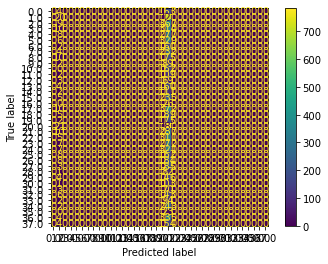

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, classification_report

lrl = LogisticRegression(multi_class='ovr', C=1e12, max_iter=5000)

model_ovr = lrl.fit(X_train, y_train)

y_pred = model_ovr.predict(X_test)

print(f'training model score: {model_ovr.score(X_train, y_train)}')
print(f'test model score: {model_ovr.score(X_test, y_test)}')
plot_confusion_matrix(lrl, X_train, y_train)
print(classification_report(y_test, y_pred))